#Objetivo

Busco analizar entre los tweets que nivel de sentimientos se muestran frente a algunas marcas como android , ios , apple , samsung , xiaomi , motorola .
Aplicando un modelo de fuzzy words y zero-shot classification

# Importación de librerias

In [ ]:
!pip install unidecode

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import time

import re
from unidecode import unidecode

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

pd.set_option('display.max_colwidth', None)

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline


In [ ]:
def estandarizar_texto(text):
  if pd.notna(text):
    text = str(text)
    text = unidecode(text).lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Zñ]+',' ', text)
  return text


def check_all_str(df,column:str):
    all_str = df[column].apply(lambda x: isinstance(x, str)).all()
    print(f"All values in the '{column}' column are strings: {all_str}")
    if not all_str:
      old = df.shape[0]
      df = df.dropna(subset=['text'])
      df.reset_index(drop=True, inplace=True)
      print(f"Dropped {old - df.shape[0]} rows with missing 'text' values.")
      print(f"Remaining rows: {df.shape[0]}")
      return df
    return df


# Data preprocessing


In [ ]:
testdata = pd.read_csv('testdata.manual.2009.06.14.csv')
testdata.head()

In [ ]:
def read_csv_with_retries(file_path, max_retries=25, delay=2):
    colnames=['sentiment','tw_id', 'date', 'no_query', 'user', 'text']
    for attempt in range(max_retries):
        try:
            df = pd.read_csv(file_path, encoding = 'latin1', names=colnames, header=None)
            return df
        except Exception as e:
            print(f"Attempt {attempt + 1} with failed: {e}")
            time.sleep(delay)
    raise Exception("Failed to read CSV file after multiple attempts")

file_path = 'training.1600000.processed.noemoticon.csv'
df = read_csv_with_retries(file_path)
df.head()

,sentiment,tw_id,date,no_query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
col_drop = ['date', 'no_query', 'user']
df = df.drop(col_drop, axis=1)

In [ ]:
df['text'] = df['text'].apply(estandarizar_texto)

In [ ]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

In [ ]:
df = check_all_str(df, 'text')

All values in the 'text' column are strings: True


In [ ]:
df.shape

(1600000, 3)

# Datos procesados

In [ ]:
df_relationships = pd.read_csv('df_relationships.csv')
df_relationships.head()

,tw_id,sentiment,user,users_tagged
0,1467810369,0,_TheSpecialOne_,['@switchfoot']
1,1467810917,0,mattycus,['@Kenichan']
2,1467811193,0,Karoli,['@nationwideclass']
3,1467811372,0,joy_wolf,['@Kwesidei']
4,1467811594,0,coZZ,['@LOLTrish']


In [ ]:
df = pd.read_csv("df_tweets.csv")
df.head()

,tw_id,text
0,1988980167,yes please
1,1880404304,much saying cant hypnotised keith barry anything
2,1680771682,great thai chicken pizza loved seeing old co workers want tiramisu red velvet cake mmmmmm
3,1979507798,bet london shows fab roll newcastle amp glasgow long away possible chance adding manc oops
4,1974662314,hey music twitters im studio happy cause completed beat need get mixed ready launch


In [ ]:
df = check_all_str(df, 'text')

All values in the 'text' column are strings: True


In [ ]:
fraction = 0.01
df_sample = df.sample(frac=fraction)
df_sample.reset_index(drop=True, inplace=True)
df_sample.shape

(15995, 2)

# Fuzzy words

Busco las marcas  android , ios , apple , samsung , xiaomi , motorola  con un modelo de fuzzy words

In [ ]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
words = ['android','ios','apple','samsung','xiaomi','motorola']

# ejemplo para ver el formato del output
sample = 'go android for the win , i love it'
best_match = process.extractOne(sample, words)
best_match

('android', 90)

In [ ]:
df_fuzzy = df.copy()
df_fuzzy['fuzzy_match'] = df_fuzzy['text'].apply(lambda x: process.extractOne(x, words))

In [ ]:
df_fuzzy['label'] = df_fuzzy['fuzzy_match'].apply(lambda x: x[0] if x[1] > 0 else None)
df_fuzzy['score'] = df_fuzzy['fuzzy_match'].apply(lambda x: x[1])

In [ ]:
df_fuzzy = df_fuzzy[df_fuzzy['score'] > 70]

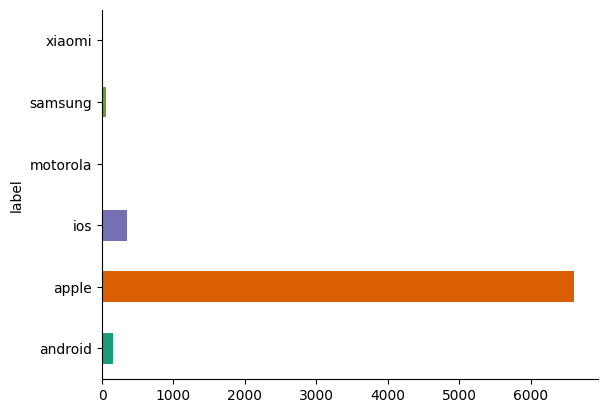

In [ ]:
df_fuzzy.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_apple = df_fuzzy[df_fuzzy["label"] == "apple"]

(6614, 5)

# Zero-shot classification
Separo aquellos tweets referidos a apple como una fruta, de los que nos interesan de apple como tecnologia.
*Tal vez podria haberlo hecho con un modelo de NER.

In [ ]:
candidate_labels = ['technology','fruit']
def classify_tweet(tweet):
    result = classifier(tweet, candidate_labels, multi_label=True)
    return pd.Series([result['labels'], result['scores']])
df_apple[["labels", "scores"]] = df_apple["text"].apply(classify_tweet)

df_apple['labels'] = df_apple.apply(lambda row: row['labels'][0], axis=1)
df_apple['scores'] = df_apple.apply(lambda row: row['scores'][0], axis=1)

In [ ]:
df_filtered = df_apple[df_apple["scores"] > 0.70]
df_filtered

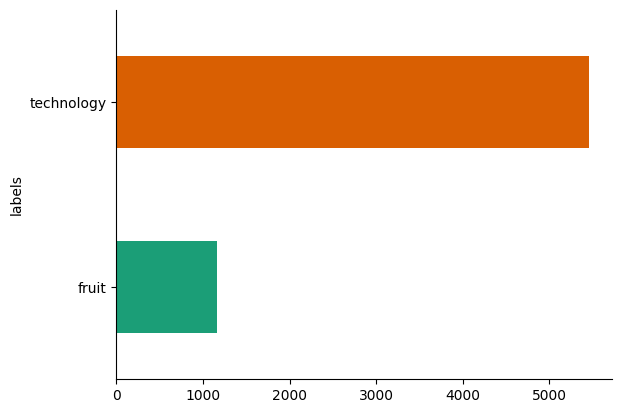

In [ ]:
df_apple.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_apple = df_apple[df_apple['labels'] == 'technology']
df_fuzzy = df_fuzzy.drop(df_fuzzy[df_fuzzy['label'] == 'apple'].index)
merged_df = pd.concat([df_fuzzy, df_apple], axis=0)
merged_df = merged_df[['tw_id', 'text', 'label']].merge(df, on='tw_id', how='left')

In [ ]:
new_df = merged_df[['tw_id', 'label', 'sentiment']]
new_df

,tw_id,label,sentiment
0,1990644644,ios,4
1,1825661693,android,4
2,1978323676,ios,4
3,1559258238,ios,4
4,2190122471,android,0
...,...,...,...
6044,2046387059,apple,4
6045,2174677042,apple,4
6046,2013794246,apple,4
6047,1834400700,apple,4


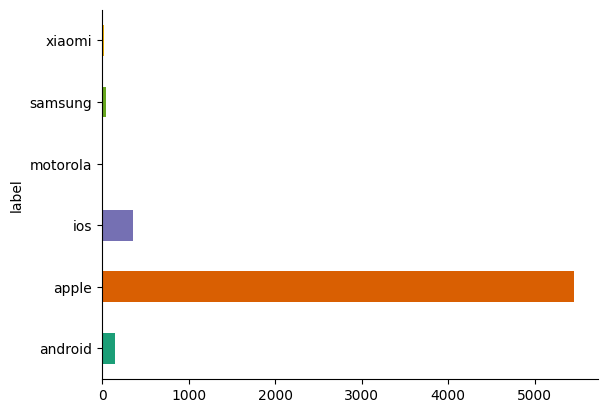

In [ ]:
new_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-106-6ae6ccee5449>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sentiment_by_label.index, y=avg_sentiment_by_label.values, palette='Set3')


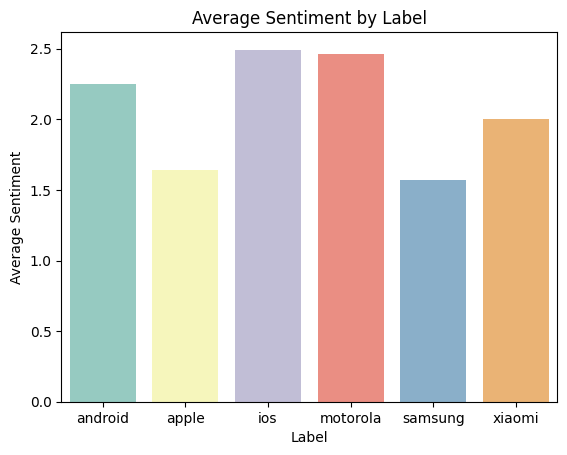

In [ ]:
# Calculate the average sentiment for each label
avg_sentiment_by_label = new_df.groupby('label')['sentiment'].mean()

# Create a bar plot of the average sentiment for each label
sns.barplot(x=avg_sentiment_by_label.index, y=avg_sentiment_by_label.values, palette='Set3')

# Set the title and axis labels
plt.title('Average Sentiment by Label')
plt.xlabel('Label')
plt.ylabel('Average Sentiment')

# Show the plot
plt.show()

# Conclusión

Encontramos que los tweets referidos a samsung y apple, luego de filtrar apple que puedan referirse a una manzana, tienen a ser negativos respecto a los tweets referidos a xiaomi (neutrales) y motorola (positivos)

En cuanto a android y ios ambos son positivos, con ios con un poco mas de puntaje